# ISLP - Chapter 7 - Exercise 7
### Author: pzuehlke

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from statsmodels.stats.anova import anova_lm

from ISLP.models import summarize , ns, ModelSpec as MS

In [2]:
Wage = pd.read_csv("Wage.csv")
Wage.dropna(inplace=True)
Wage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        3000 non-null   int64  
 1   age         3000 non-null   int64  
 2   maritl      3000 non-null   object 
 3   race        3000 non-null   object 
 4   education   3000 non-null   object 
 5   region      3000 non-null   object 
 6   jobclass    3000 non-null   object 
 7   health      3000 non-null   object 
 8   health_ins  3000 non-null   object 
 9   logwage     3000 non-null   float64
 10  wage        3000 non-null   float64
dtypes: float64(2), int64(2), object(7)
memory usage: 257.9+ KB


We will construct boxplots of `wage` against the categorical variables
`jobclass`, `maritl` (marital status), `education`, `health_ins` (health
insurance), `age` (binned by age group), `race`, `health` (self-reported health
status),  and `year`. In all cases, the categories will be
_ordered by median wage_ within each category.

Note that all of the data is collected for men from the central Atlantic region
of the US (see the description on p. $ 1 $ of the book), so the only remaining
categorical variable, `region`, is useless since it contains no information:

In [3]:
print("Region unique values:")
print(Wage["region"].unique())

print("\nRace unique values:")
print(Wage["race"].unique())

print("\nHealth unique values:")
print(Wage["health"].unique())

print("\nMarital status unique values:")
print(Wage["maritl"].unique())

print("\nEducation unique values:")
print(Wage["education"].unique())

print("\nJob class unique values:")
print(Wage["jobclass"].unique())

print("\nHealth insurance unique values:")
print(Wage["health_ins"].unique())

print("\nYear unique values:")
print(Wage["year"].unique())

Region unique values:
['2. Middle Atlantic']

Race unique values:
['1. White' '3. Asian' '4. Other' '2. Black']

Health unique values:
['1. <=Good' '2. >=Very Good']

Marital status unique values:
['1. Never Married' '2. Married' '4. Divorced' '3. Widowed' '5. Separated']

Education unique values:
['1. < HS Grad' '4. College Grad' '3. Some College' '2. HS Grad'
 '5. Advanced Degree']

Job class unique values:
['1. Industrial' '2. Information']

Health insurance unique values:
['2. No' '1. Yes']

Year unique values:
[2006 2004 2003 2005 2008 2009 2007]


Let's construct the boxplots:

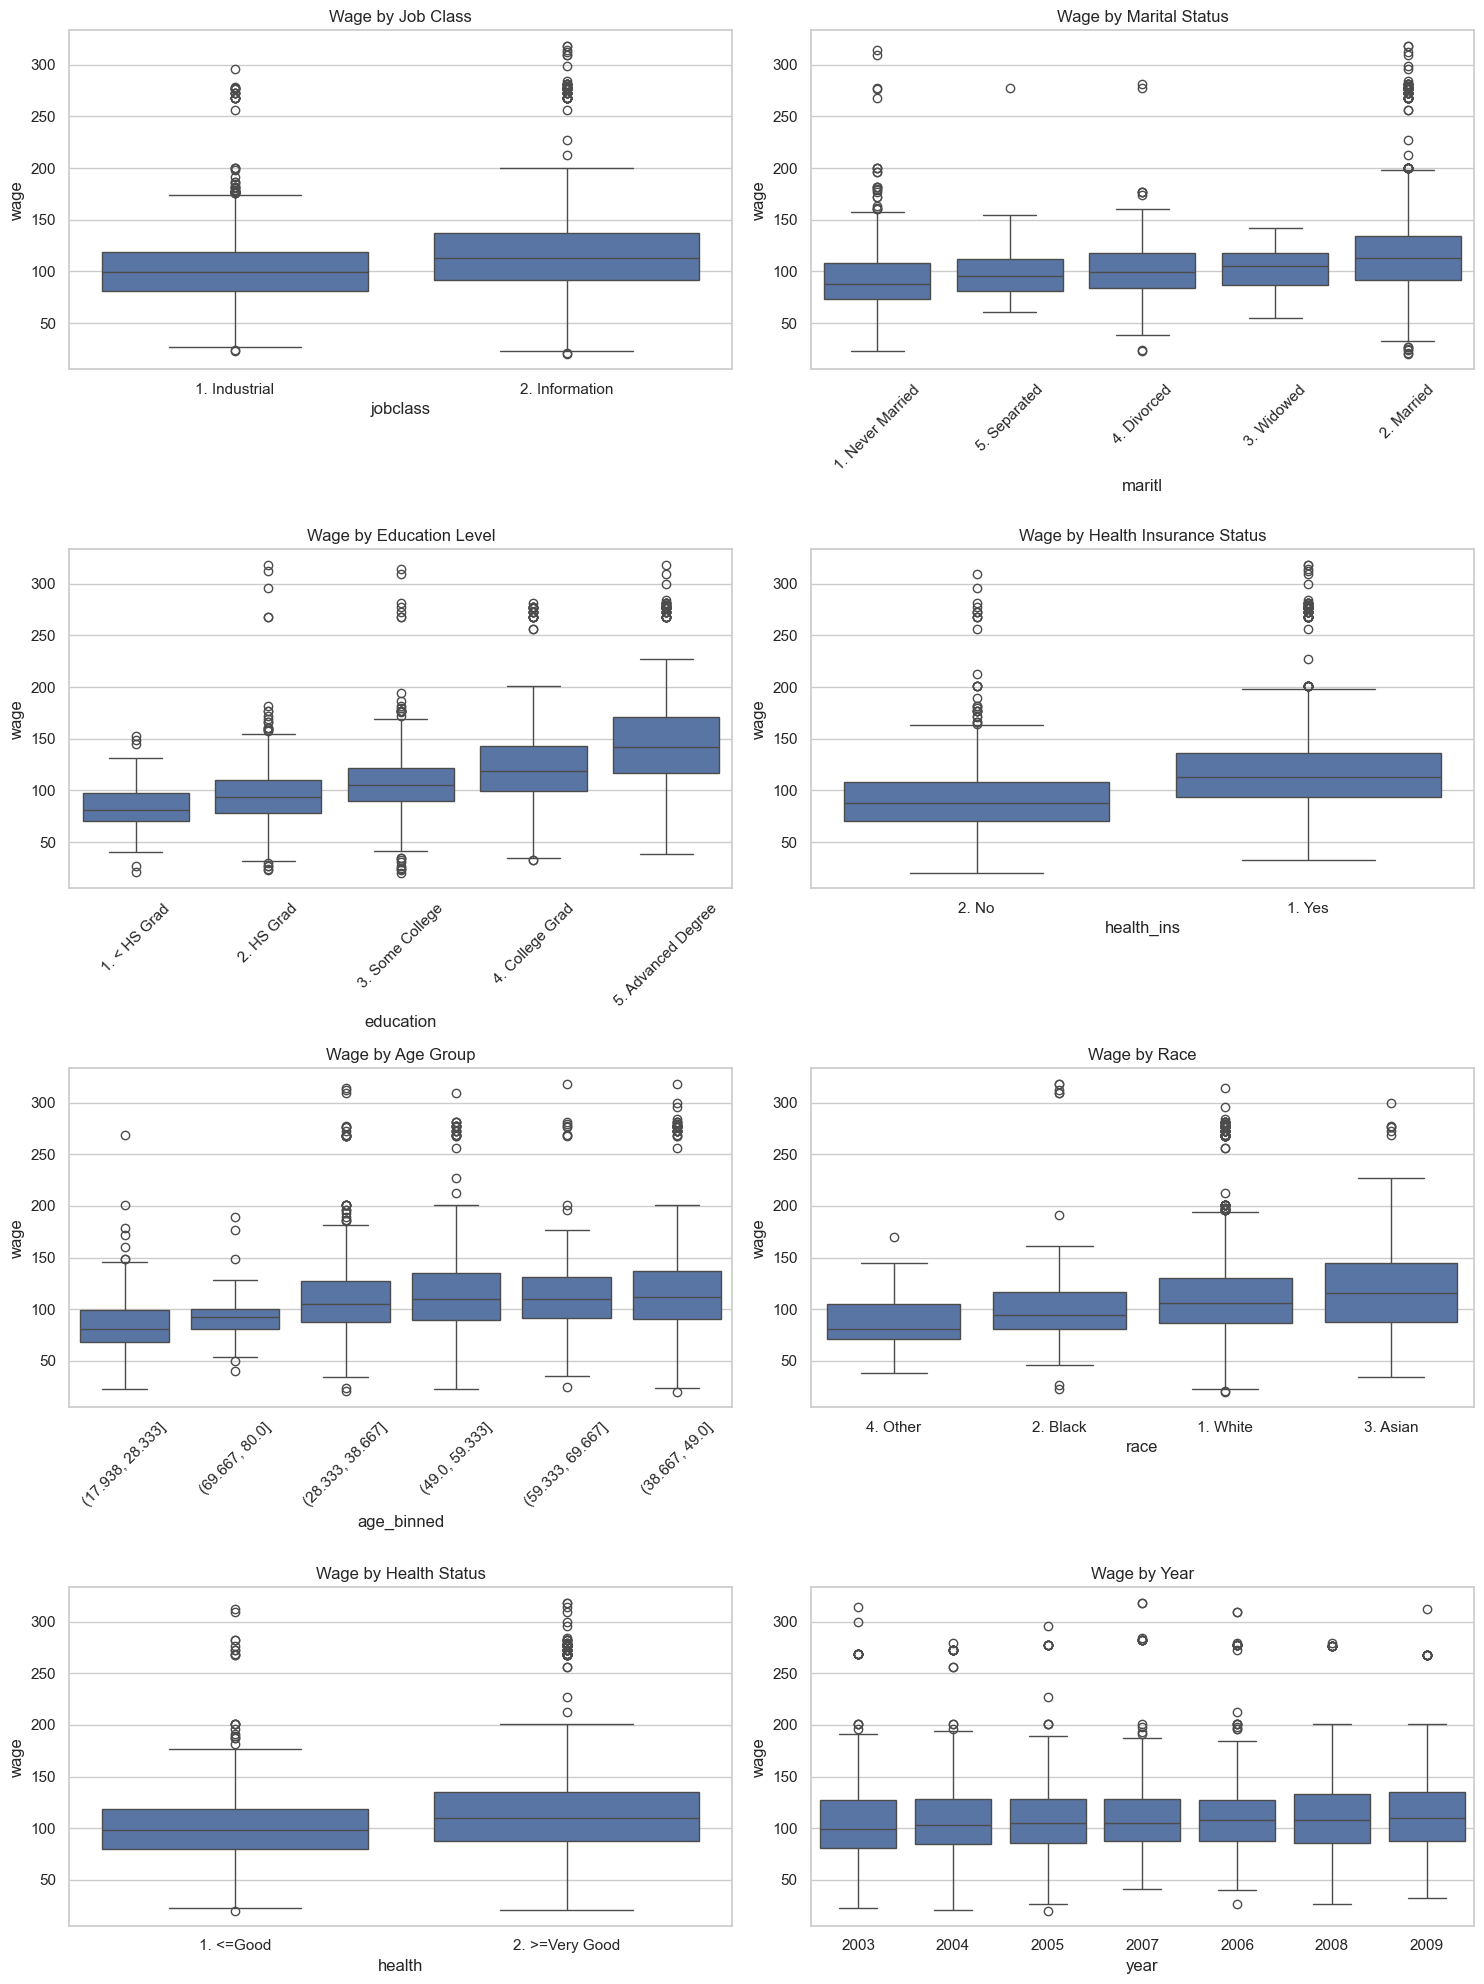

In [4]:
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(4, 2, figsize=(15, 20))

# Calculate median wages for each category:
jobclass_order = Wage.groupby("jobclass")["wage"].median().sort_values().index
maritl_order = Wage.groupby("maritl")["wage"].median().sort_values().index
education_order = Wage.groupby("education")["wage"].median().sort_values().index
health_ins_order = Wage.groupby("health_ins")["wage"].median().sort_values().index
race_order = Wage.groupby("race")["wage"].median().sort_values().index
health_order = Wage.groupby("health")["wage"].median().sort_values().index
year_order = Wage.groupby("year")["wage"].median().sort_values().index

# Doing the same for age. We first need to create the age bins:
age_bins = pd.cut(Wage["age"], bins=6)
Wage_with_bins = Wage.copy()
Wage_with_bins["age_binned"] = age_bins
age_order = Wage_with_bins.groupby("age_binned", observed=False)["wage"]\
                          .median().sort_values().index.tolist()

# Plot wage vs job class:
ax1 = axes[0, 0]
sns.boxplot(x="jobclass", y="wage", data=Wage, ax=ax1, order=jobclass_order)
ax1.set_title("Wage by Job Class")
ax1.tick_params(axis="x")

# Plot wage vs marital status:
ax2 = axes[0, 1]
sns.boxplot(x="maritl", y="wage", data=Wage, ax=ax2, order=maritl_order)
ax2.set_title("Wage by Marital Status")
ax2.tick_params(axis="x", rotation=45)

# Plot wage vs education:
ax3 = axes[1, 0]
sns.boxplot(x="education", y="wage", data=Wage, ax=ax3, order=education_order)
ax3.set_title("Wage by Education Level")
ax3.tick_params(axis="x", rotation=45)

# Plot wage vs health insurance status:
ax4 = axes[1, 1]
sns.boxplot(x="health_ins", y="wage", data=Wage, ax=ax4, order=health_ins_order)
ax4.set_title("Wage by Health Insurance Status")

# Plot wage vs age (binned for better visualization):
ax5 = axes[2, 0]
# Create age bins (e.g., 5-year intervals):
sns.boxplot(x="age_binned", y="wage", data=Wage_with_bins, ax=ax5, order=age_order)
ax5.set_title("Wage by Age Group")
ax5.tick_params(axis="x", rotation=45)

# Plot wage vs race:
ax6 = axes[2, 1]
sns.boxplot(x="race", y="wage", data=Wage, ax=ax6, order=race_order)
ax6.set_title("Wage by Race")
ax6.tick_params(axis="x")

# Plot wage vs health status:
ax7 = axes[3, 0]
sns.boxplot(x="health", y="wage", data=Wage, ax=ax7, order=health_order)
ax7.set_title("Wage by Health Status")
ax7.tick_params(axis="x")

# Plot wage vs year:
ax8 = axes[3, 1]
# Order years by mean wage:
sns.boxplot(x="year", y="wage", data=Wage, ax=ax8, order=year_order)
ax8.set_title("Wage by Year")
ax8.tick_params(axis="x", rotation=0)

fig.tight_layout()
plt.show()

We will now use scikit-learn to model the relationship between wage and age
using cubic splines with varying number of knots:

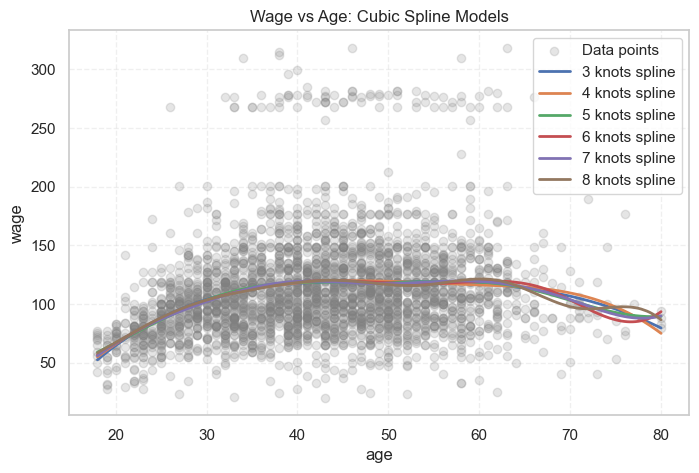

In [5]:
knots = list(range(3, 9))
X = Wage["age"].values.reshape(-1, 1)
y = Wage["wage"].values

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(X, y, alpha=0.2, color="gray", label="Data points")

# Fit spline models with different numbers of knots:
X_grid = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
for number_of_knots in knots:
    model = make_pipeline(
        SplineTransformer(n_knots=number_of_knots, degree=3),
        LinearRegression()
    )
    model.fit(X, y)
    y_pred = model.predict(X_grid)

    ax.plot(X_grid, y_pred, linewidth=2, label=f"{number_of_knots} knots spline")

ax.set_xlabel("age")
ax.set_ylabel("wage")
ax.set_title("Wage vs Age: Cubic Spline Models")
ax.legend()
ax.grid(alpha=0.3, linestyle="--")
plt.show()

Based on these plots, the number of knots in the spline doesn't seem to make much of a
difference to the fit.

Finally, let's fit and visualize a cubic natural spline regression model with $ 5 $
degrees of freedom to analyze the same relationship between age and wage. For
this part we will make use of the ISLP package and follow the code in the lab
closely.

                     coef  std err       t  P>|t|
intercept         60.4752    4.708  12.844  0.000
ns(age, df=5)[0]  61.5267    4.709  13.065  0.000
ns(age, df=5)[1]  55.6912    5.717   9.741  0.000
ns(age, df=5)[2]  46.8184    4.948   9.463  0.000
ns(age, df=5)[3]  83.2036   11.918   6.982  0.000
ns(age, df=5)[4]   6.8770    9.484   0.725  0.468


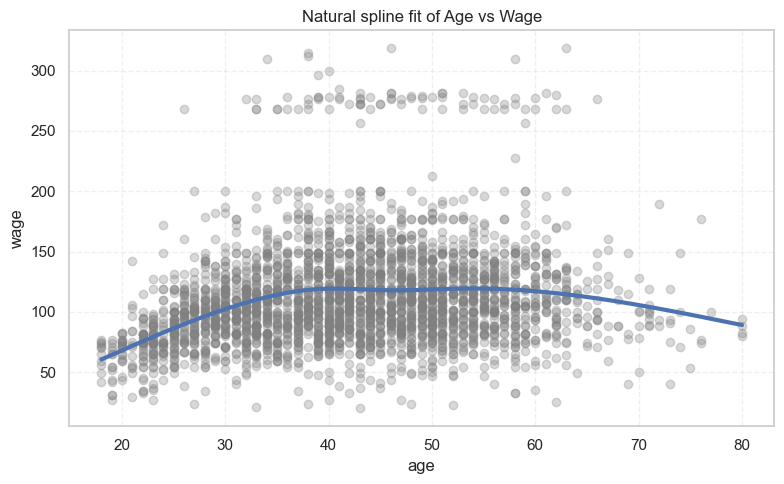

In [6]:
# Use MS to create a model specification with a natural spline:
ns_age_spec = MS([ns("age", df=5)]).fit(Wage)
M_ns = sm.OLS(y, ns_age_spec.transform(Wage)).fit()
print(summarize(M_ns))

# Create a prediction grid for age:
age_grid = pd.DataFrame({"age": np.linspace(min(Wage["age"]), max(Wage["age"]), 200)})
ns_age_preds = M_ns.predict(ns_age_spec.transform(age_grid))

# Plot the natural spline fit:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(Wage["age"], Wage["wage"], alpha=0.3, color="gray")
ax.plot(age_grid["age"], ns_age_preds, 'b-', linewidth=3)
ax.set_xlabel("age")
ax.set_ylabel("wage")
ax.set_title("Natural spline fit of Age vs Wage")
ax.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

We see that the fifth basis function is not statistically significant. Also,
from the plot we see that the natural spline is a lot less wiggly near the
boundaries of the age range, when compared to the regular the splines that
were fitted in exercise $ 6 $.  This feature was already discussed in the text.

Finally, to get a better visualization of this natural spline, we will plot it
again, but this time suppressing the data points:

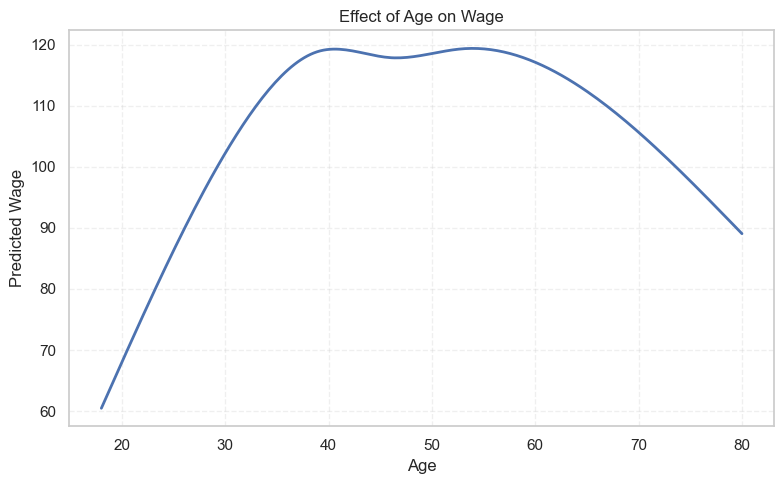

In [7]:
# Create partial dependence plots
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(age_grid["age"], ns_age_preds, 'b-', linewidth=2)
ax.set_xlabel("Age")
ax.set_ylabel("Predicted Wage")
ax.set_title("Effect of Age on Wage")
ax.grid(alpha=0.3, linestyle="--")

fig.tight_layout()
plt.show()